In [27]:
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data

In [28]:
X,y = spiral_data(100,3)

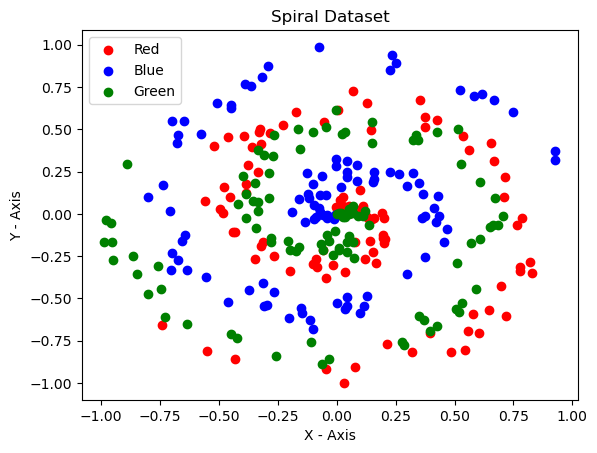

In [29]:
plt.scatter(X[:,0][y==0],X[:,1][y==0],c = 'red',label = 'Red')
plt.scatter(X[:,0][y==1],X[:,1][y==1],c = 'blue',label = 'Blue')
plt.scatter(X[:,0][y==2],X[:,1][y==2],c = 'green',label = 'Green')
plt.xlabel('X - Axis')
plt.ylabel('Y - Axis')
plt.title('Spiral Dataset')
plt.legend()
plt.show()

### Adding Building Blocks

In [30]:
class Dense:
    def __init__(self,no_of_inputs ,no_of_neurons):
        self.weights = np.random.randn(no_of_inputs, no_of_neurons) * 0.01
        self.biases = np.zeros((1, no_of_neurons))
        self.weights_momentum = np.zeros_like(self.weights)
        self.biases_momentum = np.zeros_like(self.biases)

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)


class ReluActivation:
    def forward(self, dense_output):
        self.inputs = dense_output
        self.output = np.maximum(0, dense_output)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs < 0] = 0


class Softmax:
    def forward(self, inputs):
        exp_inputs = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        sum_exp = np.sum(exp_inputs, axis=1, keepdims=True)
        self.output = exp_inputs / sum_exp
        return self.output


class CrossEntLoss:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            return -np.mean(np.log(y_pred[range(samples), y_true]))
        elif len(y_true.shape) == 2:
            return -np.mean(np.log(np.sum(y_pred * y_true, axis=1)))


class Softmax_CrossentLoss:
    def __init__(self):
        self.activation = Softmax()
        self.loss = CrossEntLoss()

    def forward(self, inputs, y_true):
        self.softmax_output = self.activation.forward(inputs)
        return self.loss.forward(self.softmax_output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs /= samples


### Adding ADAM Optimizer

In [31]:
class Optimizer_ADAM:
    def __init__(self,learning_rate = 0.001,decay = 0,epsilon = 1e-7,beta1 = 0.9,beta2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.iterations = 0

    def pre_update_params(self):
        self.current_learning_rate = self.learning_rate / (1 + self.decay*self.iterations)

    def update_params(self,layer):
    
        if not hasattr(layer,'weights_momentum'):
            layer.weights_momentum = np.zeros_like(layer.weights)
            layer.biases_momentum = np.zeros_like(layer.biases)
        
        if not hasattr(layer,'weights_cache'):
            layer.weights_cache = np.zeros_like(layer.weights)
            layer.biases_cache = np.zeros_like(layer.biases)

        t = self.iterations +1

        layer.weights_momentum = self.beta1*layer.weights_momentum + (1-self.beta1)*layer.dweights
        layer.biases_momentum = self.beta1*layer.biases_momentum + (1-self.beta1)*layer.dbiases

        weight_momentum_corrected = layer.weights_momentum / ( 1- self.beta1 ** t)
        biases_momentum_corrected = layer.biases_momentum / ( 1- self.beta1 ** t)

        layer.weights_cache = self.beta2 * layer.weights_cache + (1 - self.beta2)*(layer.dweights ** 2)
        layer.biases_cache = self.beta2 * layer.biases_cache + (1 - self.beta2)*(layer.dbiases ** 2)


        weight_cache_corrected = layer.weights_cache / ( 1- self.beta2 ** t)
        biases_cache_corrected = layer.biases_cache / ( 1- self.beta2 ** t)


        layer.weights -= (self.current_learning_rate*weight_momentum_corrected) / \
                          (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases -= (self.current_learning_rate*biases_momentum_corrected) / \
                         (np.sqrt(biases_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

### Making the Model

In [32]:
dense1 = Dense(2,64)
activation1 = ReluActivation()

dense2 = Dense(64,3)
softmax_loss = Softmax_CrossentLoss()

optimizer = Optimizer_ADAM(learning_rate=0.02,decay=1e-5)

for epochs in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    loss = softmax_loss.forward(dense2.output,y)

    prediction = np.argmax(softmax_loss.softmax_output,axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y,axis=1)

    accuracy = np.mean(prediction == y)
    if epochs % 100 == 0:
        print(f'epochs = {epochs}, loss = {loss:.3f}, acc = {accuracy:.3f}, lr = {optimizer.current_learning_rate}')


    softmax_loss.backward(softmax_loss.softmax_output,y)
    dense2.backward(softmax_loss.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)


    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epochs = 0, loss = 1.099, acc = 0.400, lr = 0.02
epochs = 100, loss = 0.874, acc = 0.560, lr = 0.01998021958261321
epochs = 200, loss = 0.653, acc = 0.703, lr = 0.019960279044701046
epochs = 300, loss = 0.562, acc = 0.743, lr = 0.019940378268975763
epochs = 400, loss = 0.495, acc = 0.787, lr = 0.01992051713662487
epochs = 500, loss = 0.452, acc = 0.810, lr = 0.01990069552930875
epochs = 600, loss = 0.418, acc = 0.827, lr = 0.019880913329158343
epochs = 700, loss = 0.385, acc = 0.833, lr = 0.019861170418772778
epochs = 800, loss = 0.360, acc = 0.833, lr = 0.019841466681217078
epochs = 900, loss = 0.342, acc = 0.850, lr = 0.01982180200001982
epochs = 1000, loss = 0.325, acc = 0.860, lr = 0.019802176259170884
epochs = 1100, loss = 0.316, acc = 0.860, lr = 0.01978258934311912
epochs = 1200, loss = 0.305, acc = 0.877, lr = 0.01976304113677013
epochs = 1300, loss = 0.296, acc = 0.883, lr = 0.019743531525483964
epochs = 1400, loss = 0.289, acc = 0.887, lr = 0.01972406039507293
epochs = 1500, 

In [33]:
# Choose a resolution
h = 0.01

# Create grid points based on your data range
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Flatten the grid and combine into input shape
grid = np.c_[xx.ravel(), yy.ravel()]

In [34]:
# Forward pass through trained model
dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
softmax_loss.forward(dense2.output, np.zeros(len(grid), dtype=int))
  # dummy labels



predictions = np.argmax(softmax_loss.softmax_output, axis=1)
Z = predictions.reshape(xx.shape)

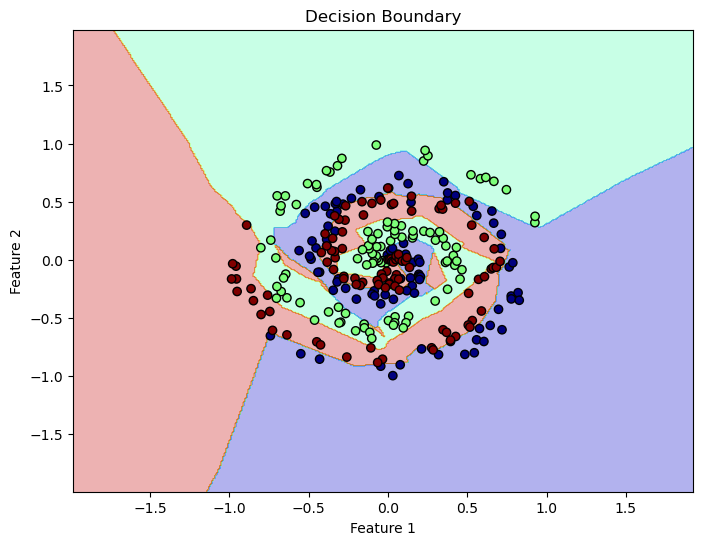

In [35]:
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap='jet', alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', edgecolors='k')
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()